<a href="https://colab.research.google.com/github/Christoforos00/NLP_project/blob/main/nlp_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import nltk
import numpy as np
import pickle

from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,  Flatten
from tensorflow.keras.optimizers import Adam


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
!gzip -d cc.en.300.bin.gz



--2021-08-16 15:22:04--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  10.8MB/s    in 6m 35s  

2021-08-16 15:28:41 (10.9 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2021-08-16 18:56:59--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  18.4MB/s    in 66s     

2021-08-16 18:58:05 (19.2 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [ ]:
from gensim.models.wrappers import FastText

fasttext = FastText.load_fasttext_format('cc.en.300.bin')

In [ ]:
i=0
vocabulary = {}

with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n', errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        print(i)
        if i==0:
            vocabulary_size = int(line[0])+2
            dim = int(line[1])
            vecs = np.zeros(vocabulary_size*dim).reshape(vocabulary_size,dim)
            vocabulary["__PADDING__"] = 0
            vocabulary["__UNK__"] = 1
            i = 2
        else:
            vocabulary[line[0]] = i
            embedding = np.array(line[1:]).astype(np.float)
            if (embedding.shape[0]==dim):
                vecs[i,:] = embedding
                i+=1
            else:
                print("Aaaaaaaaaaaaaaaaa")

        

        
        

FileNotFoundError: ignored

In [ ]:

# Serialize vocab & embeddings
pickle.dump(vocabulary, open("/content/drive/My Drive/fasttext_voc.pkl" ,'wb'))
np.save("/content/drive/My Drive/fasttext.npy", vecs)

# Free ram
vecs = None
vocabulary = None
embedding = None

NameError: ignored

In [ ]:
df = pd.read_json('/content/drive/My Drive/News_Category_Dataset_v2.json', lines=True)

In [ ]:
df

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26
...,...,...,...,...,...,...
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
df = df[:100000]

In [ ]:
df['text'] = df['headline'] + " " + df['short_description']
texts = df['text'].tolist() 
labels = df['category'].tolist()


In [ ]:
del df

In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner"])
nlp.add_pipe(nlp.create_pipe('sentencizer')) 

def tokenize_samples(samples):
  
    tokenized_samples = []
    for i in range(len(samples)):  # For each sample
        doc = nlp(samples[i])  # Tokenize the sample into sentences
        tokens = []
        for sent in doc.sents:  # For each sentence
            for tok in sent:  # Iterate through each token 
                # Preprocessing: Filter stopwords
                if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
                    continue
                if tok.text.strip():  
                    tokens.append(tok.text.replace('"',"'").strip())
        tokenized_samples.append(tokens)

    return tokenized_samples

texts_tokenized = tokenize_samples(texts)
text_edited = texts_tokenized
texts_tokenized = None

In [ ]:
from sklearn.model_selection import train_test_split  

X_train, X_test, y_train, y_test = train_test_split(text_edited, labels, test_size=0.2, random_state=101)

In [ ]:
# Load/deserialize
fasttext_embed = np.load("/content/drive/My Drive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/drive/My Drive/fasttext_voc.pkl", 'rb'))

In [ ]:
del text_edited
del labels


y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()

y_train = lb.fit_transform(y_train)
# y_dev = lb.transform(y_dev)
y_test = lb.transform(y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 250 
EMBEDDING_DIM = fasttext_embed.shape[1]

# Init tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='__UNK__')
# num_words: the maximum number of words to keep, based on word frequency.
# oov_token: will be used to replace OOV WORDS

# Fit tokenizer
tokenizer.fit_on_texts([" ".join(x) for x in X_train])

# Converts text to sequences of IDs
train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_train])
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_test])

# Pads sequences to a fixed value
X_train = pad_sequences(sequences=train_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test = pad_sequences(sequences=test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.25, random_state=101)


In [ ]:
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))

Found 59533 unique tokens.


In [ ]:
word_index = tokenizer.word_index
print('Found {} unique tokens.'.format(len(word_index)))

embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))  # +2 (pad, unknown)

for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

Found 59533 unique tokens.


In [ ]:
y_train_nonbinary = lb.inverse_transform(y_train)
y_dev_nonbinary = lb.inverse_transform(y_dev)
y_test_nonbinary = lb.inverse_transform(y_test )


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay


In [ ]:
print("Results of the majority classifier")

baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train_nonbinary)

print("Classification report on the training data:")
predictions_train = baseline.predict(X_train)
print(classification_report(y_train_nonbinary, predictions_train))

print("Classification report on the development data:")
predictions_dev = baseline.predict(X_dev)
print(classification_report(y_dev_nonbinary, predictions_dev))

print("Classification report on the test data:")
predictions_test = baseline.predict(X_test)
print(classification_report(y_test_nonbinary, predictions_test))



Results of the majority classifier
Classification report on the training data:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00       479
ARTS & CULTURE       0.00      0.00      0.00       387
  BLACK VOICES       0.00      0.00      0.00      1419
      BUSINESS       0.00      0.00      0.00      1791
       COLLEGE       0.00      0.00      0.00       344
        COMEDY       0.00      0.00      0.00      1488
         CRIME       0.00      0.00      0.00      1054
CULTURE & ARTS       0.00      0.00      0.00       297
       DIVORCE       0.00      0.00      0.00      1025
     EDUCATION       0.00      0.00      0.00       285
 ENTERTAINMENT       0.00      0.00      0.00      4864
   ENVIRONMENT       0.00      0.00      0.00       408
         FIFTY       0.00      0.00      0.00       420
  FOOD & DRINK       0.00      0.00      0.00      1827
     GOOD NEWS       0.00      0.00      0.00       381
         GREEN       0.00      0.00      0.00       767
HEALTHY LIVING       0.00      0.00      0.00  

In [ ]:
print("Results of logistic regression")

logReg = LogisticRegression(solver="liblinear", C = 10)
logReg.fit(X_train, y_train_nonbinary)

print("Classification report on the training data:")
predictions_train = logReg.predict(X_train)
print(classification_report(y_train_nonbinary, predictions_train))

print("Classification report on the development data:")
predictions_dev = logReg.predict(X_dev)
print(classification_report(y_dev_nonbinary, predictions_dev))

print("Classification report on the test data:")
predictions_test = logReg.predict(X_test)
print(classification_report(y_test_nonbinary, predictions_test))


Results of logistic regression
Classification report on the training data:
                precision    recall  f1-score   support

          ARTS       0.47      0.18      0.26       457
ARTS & CULTURE       0.46      0.16      0.23       411
  BLACK VOICES       0.49      0.27      0.35      1375
      BUSINESS       0.47      0.42      0.45      1756
       COLLEGE       0.49      0.33      0.39       368
        COMEDY       0.53      0.30      0.38      1576
         CRIME       0.56      0.55      0.55      1010
CULTURE & ARTS       0.63      0.24      0.35       331
       DIVORCE       0.78      0.64      0.70      1003
     EDUCATION       0.53      0.33      0.41       302
 ENTERTAINMENT       0.46      0.70      0.55      4868
   ENVIRONMENT       0.72      0.18      0.28       410
         FIFTY       0.39      0.07      0.11       399
  FOOD & DRINK       0.59      0.71      0.64      1916
     GOOD NEWS       0.49      0.18      0.26       439
         GREEN       0.45   

In [ ]:
import os
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        
        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [ ]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



with tf.device('/device:GPU:0'):  
    model = Sequential()
    model.add(Dense(448, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(320,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(320,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    print(model.summary())
    
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=["categorical_crossentropy"]
    )
    
    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')
        
    checkpoint = ModelCheckpoint(
        'checkpoints/weights.hdf5',
        monitor='val_accuracy',
        mode='max',
        verbose=2,
        save_best_only=True,
        save_weights_only=True
    )
    
    history= model.fit(
        X_train,
        y_train,
        validation_data= (X_dev, y_dev),
        batch_size=256,
        epochs=30,
        shuffle=True,
        callbacks=[Metrics(valid_data=(X_dev, y_dev)), checkpoint]
    )

    predictions_dev = model.predict(X_dev)
    predictions_dev = (predictions_dev > 0.5).astype(int)    
    print(classification_report(y_dev, predictions_dev, target_names=lb.classes_))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 448)               224448    
_________________________________________________________________
dropout_6 (Dropout)          (None, 448)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 320)               143680    
_________________________________________________________________
dropout_7 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 320)               102720    
_________________________________________________________________
dropout_8 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 41)               

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


235/235 [==============================] - 6s 26ms/step - loss: 2.2261 - categorical_crossentropy: 2.2261 - val_loss: 1.9780 - val_categorical_crossentropy: 1.9780
 — val_f1: 0.403841 — val_precision: 0.390308 — val_recall: 0.487300

Epoch 00002: categorical_crossentropy did not improve from 2.89812
Epoch 3/30
235/235 [==============================] - 6s 25ms/step - loss: 2.0492 - categorical_crossentropy: 2.0492 - val_loss: 1.8868 - val_categorical_crossentropy: 1.8868
 — val_f1: 0.432061 — val_precision: 0.464064 — val_recall: 0.503450

Epoch 00003: categorical_crossentropy did not improve from 2.89812
Epoch 4/30
235/235 [==============================] - 6s 25ms/step - loss: 1.9530 - categorical_crossentropy: 1.9530 - val_loss: 1.8345 - val_categorical_crossentropy: 1.8345
 — val_f1: 0.444264 — val_precision: 0.446962 — val_recall: 0.511900

Epoch 00004: categorical_crossentropy did not improve from 2.89812
Epoch 5/30
235/235 [==============================] - 6s 25ms/step - loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):

    model = Sequential()
    model.add(Dense(448, input_dim=X_train.shape[1], activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(320,activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(320,activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(y_train.shape[1],activation='softmax'))

    # Load weights from the pre-trained model
    model.load_weights("checkpoints/weights.hdf5")

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy'])
    )

    print("Classification report on the training data:")
    predictions_train = model.predict(X_train)
    predictions_train = (predictions_train > 0.5).astype(int)   
    print(classification_report(y_train, predictions_train, target_names=lb.classes_))

    print("Classification report on the development data:")
    predictions_dev = model.predict(X_dev)
    predictions_dev = (predictions_dev > 0.5).astype(int) 
    print(classification_report(y_dev, predictions_dev, target_names=lb.classes_))

    print("Classification report on the test data:")
    predictions_test = model.predict(X_test)
    predictions_test = (predictions_test > 0.5).astype(int)    
    print(classification_report(y_test, predictions_test, target_names=lb.classes_))

SyntaxError: ignored

In [ ]:
class DeepSelfAttention(layers.Layer):

    def __init__(self, input_dim, dense1_dim, dense2_dim,**kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.dense1_dim = dense1_dim
        self.dense2_dim = dense2_dim
        self.dense1 = Dense(dense1_dim)
        self.dense2 = Dense(dense2_dim)
        self.dense3 = Dense(1)

    def call(self, input):
        x = self.dense1(input)
        x = self.dense2(x)
        x = self.dense3(x)
        output = tf.nn.softmax(x, axis=-1)
        return tf.math.reduce_sum( tf.math.multiply(input,output) , axis=1 )

    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim" : self.input_dim,
            "dense1_dim" : self.dense1_dim,
            "dense2_dim" : self.dense2_dim
        })
        return config    

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 97 kB 4.9 MB/s 


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam

In [ ]:
#hyperparameter tuning

def build_model(hp):
    GRU_SIZE = 64
    DENSE = hp.Int('dense' , min_value=32, max_value=416, step=128)
    DROPOUT = hp.Float('dropout' , min_value=0.2, max_value=0.5, step=0.15)
    ATTENTION_DENSE1 = hp.Int('att_dense1' , min_value=32, max_value=416, step=128)
    ATTENTION_DENSE2 = hp.Int('att_dense2' , min_value=32, max_value=416, step=128)
    STACKED_GRUs = hp.Int('GRUs' , min_value=1, max_value=4, step=1)

    model = Sequential()
    model.add(Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix]
                    ,input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
    model.add(Dropout(DROPOUT))

    for i in range(STACKED_GRUs):
        model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=True)))
        model.add(Dropout(DROPOUT))

    model.add(DeepSelfAttention(MAX_SEQUENCE_LENGTH, ATTENTION_DENSE1, ATTENTION_DENSE2))
    model.add(Dropout(DROPOUT))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1],activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        metrics=["accuracy"]
    )
    return model


from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=10,
    executions_per_trial=2,
    overwrite=True )

tuner.search_space_summary()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


Search space summary
Default search space size: 6
dense (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 416, 'step': 128, 'sampling': None}
dropout (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.15, 'sampling': None}
att_dense1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 416, 'step': 128, 'sampling': None}
att_dense2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 416, 'step': 128, 'sampling': None}
GRUs (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
with tf.device('/device:GPU:0'):  
    tuner.search(X_train, y_train,
                epochs=8,
                batch_size = 256,
                validation_data=(X_dev, y_dev))
    
    best_model = tuner.get_best_models()[0]

    best_model.save('/savedModels/bestGRUatt')

Trial 10 Complete [00h 23m 40s]
accuracy: 0.5806083381175995

Best accuracy So Far: 0.6093166768550873
Total elapsed time: 03h 12m 47s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Assets written to: /savedModels/bestGRUatt/assets


INFO:tensorflow:Assets written to: /savedModels/bestGRUatt/assets


In [ ]:
best_model = tuner.get_best_models()[0]

best_model.save('/savedModels/bestGRUatt')

In [ ]:
new_model = tf.keras.models.load_model('/savedModels/bestGRUatt')

In [ ]:


with tf.device('/device:GPU:0'):
    GRU_SIZE = 64
    DENSE = 32

    model = Sequential()
    model.add(Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix]
                    ,input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
    model.add(Dropout(0.33))

    model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=True)))
    model.add(Dropout(0.33))

    model.add(DeepSelfAttention(MAX_SEQUENCE_LENGTH, 100))
    model.add(Dropout(0.33))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1],activation='softmax'))

    print(model.summary())
    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

    if not os.path.exists('/content/gdrive/My Drive/checkpoints'):
        os.makedirs('/content/gdrive/My Drive/checkpoints')

    checkpoint = ModelCheckpoint('/content/gdrive/My Drive/checkpoints/BiGRUMLP.hdf5',
                            monitor='val_accuracy', 
                            mode='max', verbose=2,
                            save_best_only=True,
                            save_weights_only=True)

    history = model.fit(X_train,
                    y_train,
                    validation_data = (X_dev,y_dev),
                    batch_size=256,
                    epochs=50,
                    shuffle=True,
                    callbacks= [Metrics(valid_data=(X_dev,y_dev)), checkpoint] )


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 300)          30000600  
_________________________________________________________________
dropout (Dropout)            (None, 250, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 128)          140544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
deep_self_attention (DeepSel (None, 128)               13001     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 — val_f1: 0.465835 — val_precision: 0.488547 — val_recall: 0.521750

Epoch 00001: val_accuracy improved from -inf to 0.52175, saving model to /content/gdrive/My Drive/checkpoints/BiGRUMLP.hdf5
Epoch 2/30
235/235 [==============================] - 30s 127ms/step - loss: 1.9453 - accuracy: 0.4937 - val_loss: 1.7536 - val_accuracy: 0.5402
 — val_f1: 0.492048 — val_precision: 0.514563 — val_recall: 0.540200

Epoch 00002: val_accuracy improved from 0.52175 to 0.54020, saving model to /content/gdrive/My Drive/checkpoints/BiGRUMLP.hdf5
Epoch 3/30
235/235 [==============================] - 30s 128ms/step - loss: 1.8374 - accuracy: 0.5149 - val_loss: 1.6903 - val_accuracy: 0.5531
 — val_f1: 0.508575 — val_precision: 0.528597 — val_recall: 0.553150

Epoch 00003: val_accuracy improved from 0.54020 to 0.55315, saving model to /content/gdrive/My Drive/checkpoints/BiGRUMLP.hdf5
Epoch 4/30
235/235 [==============================] - 30s 128ms/step - loss: 1.7802 - accuracy: 0.5279 - val_loss: 1.6561 

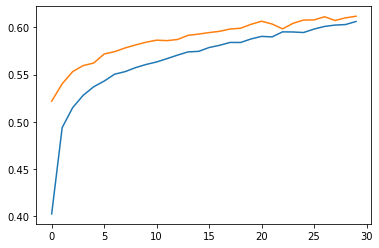

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
import warnings
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

with tf.device('/device:GPU:0'):
    GRU_SIZE = 64
    DENSE = 32

    model = Sequential()
    model.add(Embedding(input_dim=MAX_WORDS+2, output_dim=EMBEDDING_DIM, weights=[embedding_matrix]
                    ,input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))
    model.add(Dropout(0.33))

    model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=True)))
    model.add(Dropout(0.33))

    model.add(DeepSelfAttention(MAX_SEQUENCE_LENGTH, 100))
    model.add(Dropout(0.33))
    model.add(Flatten())
    model.add(Dense(y_train.shape[1],activation='softmax'))

    print(model.summary())
    model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=0.001),
                metrics=['accuracy'])

    # Load weights from the pre-trained model
    model.load_weights('/content/gdrive/My Drive/checkpoints/BiGRUMLP.hdf5')

    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=["categorical_crossentropy"]
    )

    print("Classification report on the training data:")
    predictions_train = model.predict(X_train)
    predictions_train = (predictions_train > 0.5).astype(int)   
    print(classification_report(y_train, predictions_train, target_names=lb.classes_))

    print("Classification report on the development data:")
    predictions_dev = model.predict(X_dev)
    predictions_dev = (predictions_dev > 0.5).astype(int) 
    print(classification_report(y_dev, predictions_dev, target_names=lb.classes_))

    print("Classification report on the test data:")
    predictions_test = model.predict(X_test)
    predictions_test = (predictions_test > 0.5).astype(int)    
    print(classification_report(y_test, predictions_test, target_names=lb.classes_))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 300)          30000600  
_________________________________________________________________
dropout_3 (Dropout)          (None, 250, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 250, 128)          140544    
_________________________________________________________________
dropout_4 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
deep_self_attention_1 (DeepS (None, 128)               13001     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.77      0.15      0.25       458
ARTS & CULTURE       0.69      0.12      0.21       380
  BLACK VOICES       0.68      0.32      0.44      1420
      BUSINESS       0.70      0.32      0.44      1711
       COLLEGE       0.57      0.29      0.39       329
        COMEDY       0.78      0.33      0.46      1549
         CRIME       0.71      0.41      0.52      1016
CULTURE & ARTS       0.86      0.33      0.48       323
       DIVORCE       0.93      0.64      0.76      1040
     EDUCATION       0.64      0.15      0.24       305
 ENTERTAINMENT       0.77      0.63      0.69      4719
   ENVIRONMENT       0.72      0.35      0.47       419
         FIFTY       0.73      0.15      0.24       427
  FOOD & DRINK       0.74      0.73      0.74      1846
     GOOD NEWS       0.75      0.08      0.14       423
         GREEN       0.67      0.14      0.24       767
HEALTHY LIVING       0.72      0.11      0.19  